# Podstawy Sieci Neuronowych
## Projekt 2
*Autor:* Aliaksandr Kandrat  
*Nr. indeksu:* 264290  
*Semestr:* 5  
*Grupa:* Poniedziałek, 9:15-11:00  
*Prowadzący:* Dr. inż. Piotr Ciskowski  

### Wstęp
Tematem tego projektu było zapoznanie się z **sieciami głębokimim**. Jako temat projektu wybrałem konwolucyjną sięć neuronową  
do klasyfikacji obrazów ze zbioru **CIFAR-10** (*Canadian Institute For Advanced Research*). Poniżej można znaleźć pełny kod  
źródłowy projektu z opisem poszczególnych etapów. Kod projektu został stworzony w środowiku **Jupyter** przy użyciu języka  
programowania **Python** oraz następnych biliotek:  
- **TensorFlow** - biblioteka dla tworzenia własnych sieci neuronowych oraz uczenia maszynowego, stworzona przez Google.
- **Keras** - wysokopoziomowy interfejs biblioteki *TensorFlow*.
- **NumPy** - biblioteka dodająca obsługę dużych wielowymiarowych macierzy i tabel oraz operacji matematycznych.
- **Matplotlib** - biblioteka pozwalająca na stworzenie różnego rodzaju wykresów.  

Podczas tworzenia projektu korzystałem z różnych źródeł informacji. Jako poradnik dla bibliotek **TensorFlow** oraz **Keras**  
wykorzystałem książkę *"Deep Learning with Python, Second Edition"* ***Francois Chollet*** ([książka na Oreilly](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864/)).


### Importowanie zależności
Poniżej jest przedstawiona pełna lista wykorzystanych narzędzi. Znajdują się tutaj między innymi ww. biblioteki  
jak **Tensorflow**: ` import tensorflow as tf`, **Keras**:` from tensorflow import keras` oraz inne. Natomiast  
jedną z najwazniejszych liniej poniżej jest `from keras.datasets import cifar10`. Biblioteka **Keras** zawiera  
w sobie kilka gotowych zbiorów danych, jednym z których jest **CIFAR-10**. Wyżej wymieniona linijka kodu pozwala  
na pobranie danych oraz wykorzystanie ich w swoim projekcie.

In [40]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import cifar10
from keras import layers
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy

### Opis problemu
Zbiór danych **CIFAR-10** składa się z 60,000 kolorowych obrazów o rozmiarze *32x32* pikseli. Obrazy te są podpisane  
i podzielone na **10 kategorii**:
| Etykieta | Opis          |
|----------|------------|
|     0    | airplane   |
|     1    | automobile |
|     2    | bird       |
|     3    | cat        |
|     4    | deer       | 
|     5    | dog        |
|     6    | frog       |
|     7    | horse      |
|     8    | ship       |
|     9    | truck      |

Zbiór składa się z 6,000 obrazów z każdej kategorii (klasy). Głównym zadaniem jest stworzenie sieci neuronowej do klasyfi-  
kacji obrazów na podstawie tych danych.  

Dane ze zbioru przygotowanego przez **Keras** możemy pobrać następująco:

In [41]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Komenda `cifar10.load_data()` zwraca dwa zbiory:
- **Zbiór uczący** (*training set*) - zbiór skłąda się z 50,000 obrazów przypisanych do `x_train` oraz odpowiadających etykiet `y_train`
- **Zbiór testujący** (*testing set*) - zbiór składa się z 10,000 obrazów przypisanych do `x_test` oraz odpowiadających etykiet `y_test`  

Wszyskie obrazy są przedstawione w postaci liczbowej jako macierze o rozmiarach (32, 32, 3). Pierwsze dwie liczby rozmiaru obrazu  
odpowiadają szyrokości oraz wysokości obrazu w pikselach, natomiast trzecia liczba przedstawia ilośc kanałów kolorowych, z których  
obraz się składa (w naszym wypadku kanałów jest tzy - **RGB**). Każdy element macierzy jest wartościa w zakresie [0, 255].  
Natomiast etykiety dla poszczególnych obrazów są przechowywane jako wektory kolumnowe, zawierające liczby odpowiadające klasie obrazów [0...9].  

Sprawdzając rozmiary zmiennych przechowujących dane możemy sprawdzić dokładną ilość obrazów oraz etykiet w każdym zbiorze.

In [42]:
print(f"Train images shape: {x_train.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test images shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


Przy pomocy listy (a dokładniej 'krotki', *ang. tuple*) `LABELS` możemy przedstawić wszyskie klasy obrazów. Każdemu indeksowi  
listy [0...9] odpowiada jej opis:

In [43]:
LABELS = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Następnie, tworzymy zmienne wspomagające, które definiują ilość przykładów które zostaną wykorzystane dla uczenia,  
sprawdzania oraz testowania modelu. Zmienna `N_CLASSES` przechowuje ilość klas, do których należą obrazy ze zbioru.

In [44]:
N_TRAIN_SAMPLES = 50000 # number of samples to use for training
N_VAL_SAMPLES = 5000    # number of samples to use for validation
N_TEST_SAMPLES = 10000  # number of samples to use for testing
N_CLASSES = 10          # number of image classes

Wykorzystując zmienne zdefiniowane w poprzednim fragmencie kodu pobieramy ze zbiorów zdefiniowaną ilość przykładów.  
Dodatkowo, stworzymy nowy zbiór `(x_val, y_val)` - *zbiór sprawdzający*.  
Podział danych na zbiory jest bardzo ważną częścią projektu, ponieważ każdy ze zbiorów pełni swoją fukcję:
- **Zbiór uczący** (*training set*) - jest wykorzystany do uczenia modelu. Parametry wewnętrzne modelu (wagi) są zmieniane w zależności  
od wyników dokładności (funkcji strat, *ang. loss function*), które model otrzymuje na zbiorze uczącym.
- **Zbiór sprawdzający** (*validation set*) - zbiór ten jest wykorzystywany podczas uczenia modelu do oceny poprawności jego dzialania  
na danych, których dotychczas nigdy "nie widział" (które nie były wykorzystane do uczenia modelu). Ważne jest, że podczas uczenia model  
***nie zmienia swoich parametrów*** (*nie uczy się*) na podstawie danych ze zbioru sprawdzającego.
- **Zbiór testujący** (*testing set*) - zbiór ten jest wykorzystywany do testowania działania modelu po zakończeniu procesu uczenia.

In [45]:
x_train = x_train[:N_TRAIN_SAMPLES].copy()
y_train = y_train[:N_TRAIN_SAMPLES].copy()

x_val = x_test[:N_VAL_SAMPLES].copy()
y_val = y_test[:N_VAL_SAMPLES].copy()

x_test = x_test[:N_TEST_SAMPLES].copy()
y_test = y_test[:N_TEST_SAMPLES].copy()

In [60]:
print(f"Train images shape: {x_train.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Validation images shape: {x_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test images shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Train images shape: (45000, 32, 32, 3)
Train labels shape: (45000, 10)
Validation images shape: (5000, 32, 32, 3)
Validation labels shape: (5000, 10)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 10)


Poniższy fragment kodu pobiera pierwsze 25 przykładowych obrazów ze zbioru `x_train`. Wyniki są przedstawione na wykresach  
poniżej, wraz z odpowiednimi etykietami:

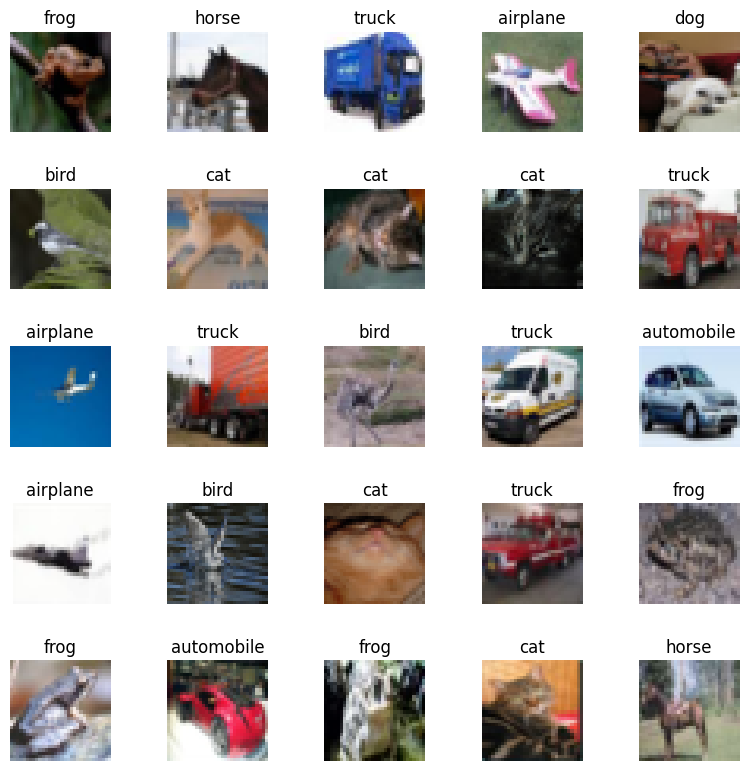

In [47]:
fig, axes = plt.subplots(5, 5, figsize=[8, 8])
fig.tight_layout(pad=1.0)
axes = axes.ravel()
for i in range (25):
  axes[i].imshow(x_train[i])
  axes[i].set_title(LABELS[y_train[i][0]])
  axes[i].axis('off')

plt.show()

### Przygotowanie danych
Ważnym etapem przygotowania danych jest skalowanie wartości wejsciowych. W tym momencie, jak wspomniano powyżej,   
wartości wewnątrz macierzy reprezentujących obrazy znajdują się w zakresie [0...255]. Musimy je przeskalować tak,  
aby mieścili się w zakresie [0...1]. W tym celu zmieniamy typ zmiennych przechowujących obrazy z 
"int8" na "float32" oraz dzielimy je przez 255.

In [48]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_val = x_val.astype("float32") / 255

Reprezentacja etykiet obrazów też musi zostać zmieniona. W tym momencie, etykiety np. `y_train` są przedstawione przy pomocy  
wektora kolumnowego, np. `y_test = [[1], [2], [0]...[5]]`, gdzie dla każdego obrazu jest przypisana jedna wartość skalarna,  
odpowiadająca klasie do której ten obraz należy. Natomiast na wyjściu naszego modelu dla każdego obrazu uzyskamy wektor o roz-  
miarze `(N_CLASSES, ) = (10, )`, w którym każdy element wektora będzie wskazywał prawdopodobieństwo przynależności danego  
obrazu do klasy, np. `model_out = [0.1, 0.9, 0.03...0.001]`.  

W naszym wypadku, etykiety obrazów gwarantują że obraz należy do jednej klasy. Wtedy możemy reprezentować etykietę `n` nie jako  
skalar, tylko jako listę prawdopodobieństw, której wszyskie elementy są równe `0`, a element pod indeksem `n` jest równy 1.  
Przykład: `y_train = 4`, `to_categorical(y_train, 10) = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`.  

Takie kodowanie wartości nazywa się **"one-hot encoding"**.

In [ ]:
y_train = to_categorical(y_train, N_CLASSES)
y_test = to_categorical(y_test, N_CLASSES)
y_val = to_categorical(y_val, N_CLASSES)

In [49]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

dog


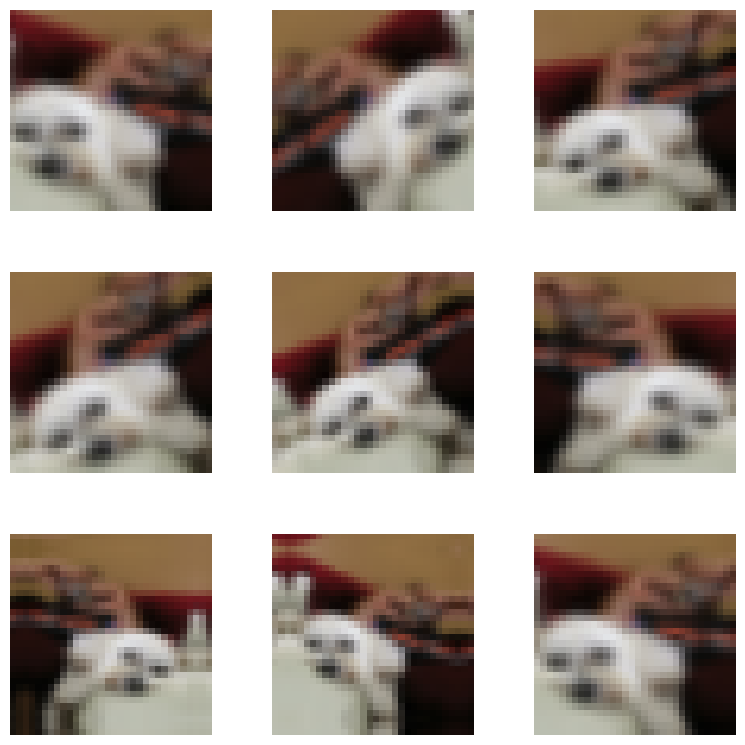

In [50]:
image_id = 4
image = x_train[image_id]
label = np.argmax(y_train[image_id])
print(LABELS[label])
fig, axes = plt.subplots(3, 3, figsize=[8, 8])
fig.tight_layout(pad=1.0)
axes = axes.ravel()
for i in range(9):
    augmented_image = data_augmentation(image)
    axes[i].imshow(augmented_image)
    axes[i].axis('off')

plt.show()

In [51]:
model = keras.models.Sequential()
model.add(layers.Input(shape=(32, 32, 3)))
model.add(data_augmentation)
model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.25))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.5))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.5))
model.add(layers.MaxPooling2D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=N_CLASSES, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 32, 3)               0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_14 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_15 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_8 (Dropout)         (None, 32, 32, 32)       

In [52]:
model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy'])

In [53]:
N_EPOCHS = 100
history = model.fit(x_train, y_train, batch_size=128, epochs=N_EPOCHS, validation_data=(x_test, y_test))

2024-01-28 19:15:09.336573: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.


Epoch 1/100


2024-01-28 19:15:16.242225: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


352/352 [==============================] - 16s 32ms/step - loss: 1.8509 - accuracy: 0.3781 - val_loss: 2.1013 - val_accuracy: 0.2673
Epoch 2/100
352/352 [==============================] - 10s 29ms/step - loss: 1.3888 - accuracy: 0.5065 - val_loss: 1.2167 - val_accuracy: 0.5529
Epoch 3/100
352/352 [==============================] - 11s 32ms/step - loss: 1.2219 - accuracy: 0.5682 - val_loss: 1.3543 - val_accuracy: 0.5220
Epoch 4/100
352/352 [==============================] - 10s 30ms/step - loss: 1.1195 - accuracy: 0.6040 - val_loss: 1.2207 - val_accuracy: 0.5631
Epoch 5/100
352/352 [==============================] - 10s 29ms/step - loss: 1.0353 - accuracy: 0.6358 - val_loss: 1.3275 - val_accuracy: 0.5263
Epoch 6/100
352/352 [==============================] - 10s 28ms/step - loss: 0.9836 - accuracy: 0.6588 - val_loss: 0.9632 - val_accuracy: 0.6556
Epoch 7/100
352/352 [==============================] - 11s 30ms/step - loss: 0.9337 - accuracy: 0.6754 - val_loss: 1.2067 - val_accuracy: 0.56

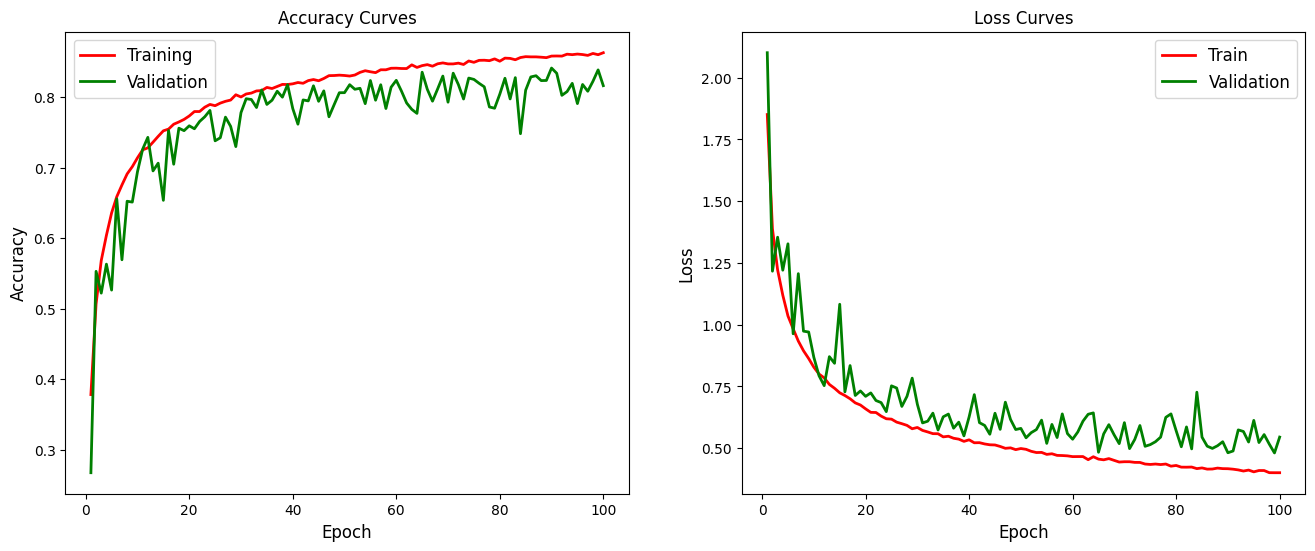

In [54]:
plt.figure(figsize=[16, 6])
plt.subplot(1, 2, 1)
plt.plot(range(1, N_EPOCHS+1), history.history['accuracy'], color="red", linewidth="2.0", label="Training")
plt.plot(range(1, N_EPOCHS+1), history.history['val_accuracy'], color="green", linewidth="2.0", label="Validation")
plt.title("Accuracy Curves")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=12)


plt.subplot(1, 2, 2)
plt.plot(range(1, N_EPOCHS+1), history.history['loss'], color="red", linewidth="2.0", label="Train")
plt.plot(range(1, N_EPOCHS+1), history.history['val_loss'], color="green", linewidth="2.0", label="Validation")
plt.title("Loss Curves")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [59]:
N_PREDS = 25
pred_images = x_test[:N_PREDS]
pred_labels = y_test[:N_PREDS]

predictions = model.predict(pred_images)
print(predictions.shape)
predictions = np.argmax(predictions, axis=1)
print(predictions.shape)
print(predictions)

1/1 [==============================] - 0s 160ms/step
(25, 10)
(25,)
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 4]


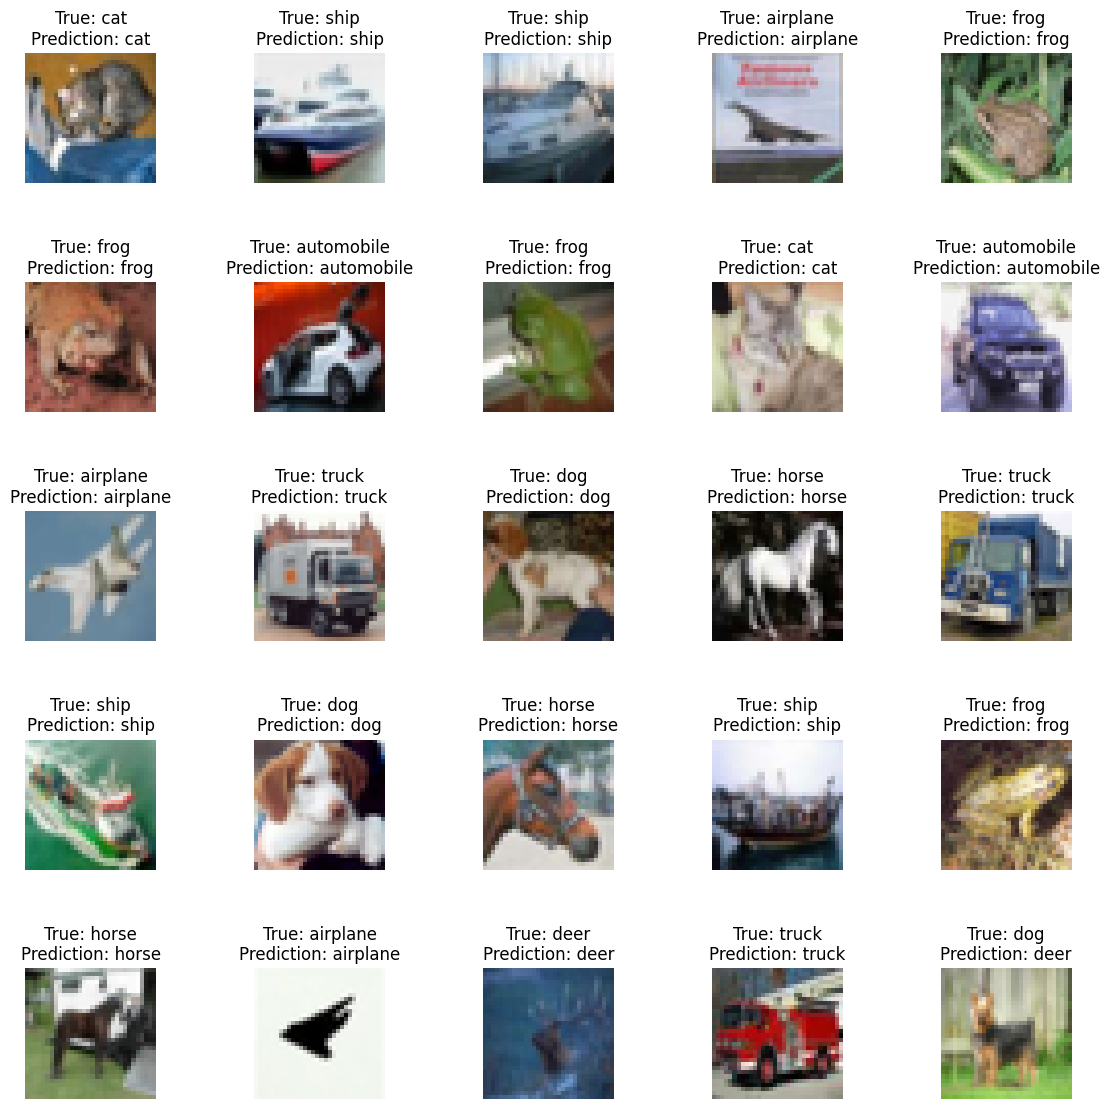

In [56]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
fig.tight_layout(pad=4.0)
axes = axes.ravel()

for i in range(0, N_PREDS):
    axes[i].imshow(pred_images[i])
    axes[i].set_title(f"True: {LABELS[np.argmax(pred_labels[i])]}\nPrediction: {LABELS[predictions[i]]}")
    axes[i].axis('off')

plt.show()

In [57]:
test_results = model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.5450 - accuracy: 0.8162


In [58]:
print(f"Test Accuracy: {test_results[1]}\nTest Loss: {test_results[0]}")

Test Accuracy: 0.8162000179290771
Test Loss: 0.5449661612510681
